In this exercise, we will be dealing with the NER for Medical problem

# Import libs

In [1]:
import os
from typing import List, Dict, Tuple
import numpy as np
import evaluate

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer

# Data

## Load data

The data was manually downloaded and unzipped from [MACCROBAT](https://figshare.com/articles/dataset/MACCROBAT2018/9764942)

## Preprocess Data

The data contains 2 types: .txt containing the text and .ann containing the labels. The .ann is fromatted according to [BioNLP Shared Task standoff
format](https://brat.nlplab.org/standoff.html):

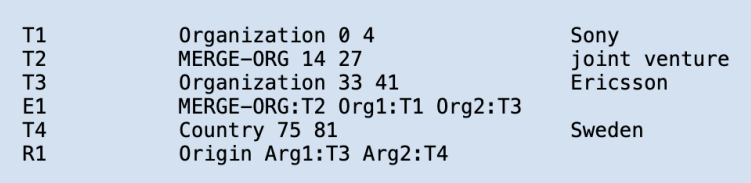

Because T is for entity, we only use the T lines

In [2]:
class PreprocessingMaccrobat:
    def __init__(self, dataset_folder, tokenizer):
        self.file_ids = [f.split(".")[0] for f in os.listdir(dataset_folder) if f.endswith('.txt')]

        self.text_files = [f+".txt" for f in self.file_ids]
        self.anno_files = [f+".ann" for f in self.file_ids]

        self.num_samples = len(self.file_ids)

        self.texts: List[str] = []
        for i in range(self.num_samples):
            file_path = os.path.join(dataset_folder, self.text_files[i])
            with open(file_path, 'r', encoding='utf8') as f:
                self.texts.append(f.read())

        self.tags: List[Dict[str, str]] = []
        for i in range(self.num_samples):
            file_path = os.path.join(dataset_folder, self.anno_files[i])
            with open(file_path, 'r', encoding='utf8') as f:
                text_bound_ann = [t.split("\t") for t in f.read().split("\n") if t.startswith("T")]
                text_bound_lst = []
                for text_b in text_bound_ann:
                    label = text_b[1].split(" ")
                    try:
                        _ = int(label[1])
                        _ = int(label[2])
                        tag = {
                            "text": text_b[-1],
                            "label": label[0],
                            "start": label[1],
                            "end": label[2]
                        }
                        text_bound_lst.append(tag)
                    except:
                        pass

                self.tags.append(text_bound_lst)
        self.tokenizer = tokenizer

    def preprocess(self) -> Tuple[List[List[str]], List[List[str]]]:
        input_texts = []
        input_labels = []

        for idx in range(self.num_samples):
            full_text = self.texts[idx]
            tags = self.tags[idx]

            label_offset = []
            continuous_label_offset = []
            for tag in tags:
                offset = list(range(int(tag["start"]), int(tag["end"])+1))
                label_offset.append(offset) # 345
                continuous_label_offset.extend(offset) #  345

            all_offset = list(range(len(full_text)))
            zero_offset = [offset for offset in all_offset if offset not in continuous_label_offset]
            zero_offset = PreprocessingMaccrobat.find_continuous_ranges(zero_offset) # 012 67

            self.tokens = []
            self.labels = []
            self._merge_offset(full_text, tags, zero_offset, label_offset)
            assert len(self.tokens) == len(self.labels), f"Length of tokens and labels are not equal"

            input_texts.append(self.tokens)
            input_labels.append(self.labels)

        return input_texts, input_labels

    def _merge_offset(self, full_text, tags, zero_offset, label_offset):
        # zero: [[0,1,2], [6,7]] label: [[3,4,5]]
        i = j = 0
        while i < len(zero_offset) and j < len(label_offset):
            if zero_offset[i][0] < label_offset[j][0]:
                self._add_zero(full_text, zero_offset, i)
                i += 1
            else:
                self._add_label(full_text, label_offset, j, tags)
                j += 1

        while i < len(zero_offset):
            self._add_zero(full_text, zero_offset, i)
            i += 1

        while j < len(label_offset):
            self._add_label(full_text, label_offset, j, tags)
            j += 1

    def _add_zero(self, full_text, offset, index):
        start, *_ ,end =  offset[index] if len(offset[index]) > 1 else (offset[index][0], offset[index][0]+1)
        text = full_text[start:end]
        text_tokens = self.tokenizer.tokenize(text)

        self.tokens.extend(text_tokens)
        self.labels.extend(
            ["O"]*len(text_tokens)
        )

    def _add_label(self, full_text, offset, index, tags):
        start, *_ ,end =  offset[index] if len(offset[index]) > 1 else (offset[index][0], offset[index][0]+1)
        text = full_text[start:end]
        text_tokens = self.tokenizer.tokenize(text)

        self.tokens.extend(text_tokens)
        self.labels.extend(
            [f"B-{tags[index]['label']}"] + [f"I-{tags[index]['label']}"]*(len(text_tokens)-1)
        )

    @staticmethod
    def build_label2id(tokens: List[List[str]]):
        label2id = {}
        id_counter = 0
        for token in [token for sublist in tokens for token in sublist]:
            if token not in label2id:
                label2id[token] = id_counter
                id_counter += 1
        return label2id 

    @staticmethod
    def find_continuous_ranges(data: List[int]): # [0, 1, 2, 6, 7]
        if not data:
            return []
        ranges = []
        start = data[0] # 0
        prev = data[0] # 0
        for number in data[1:]: # [1, 2, 6, 7]
            if number != prev + 1:
                ranges.append(list(range(start, prev + 1)))
                start = number
            prev = number
        ranges.append(list(range(start, prev + 1)))
        return ranges


In [3]:
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")

dataset_dir = "./MACCROBAT2018"
dataset = PreprocessingMaccrobat(dataset_dir, tokenizer)
input_texts, input_labels = dataset.preprocess()

label2id = PreprocessingMaccrobat.build_label2id(input_labels)
id2label = {v: k for k, v in label2id.items()}

## Split data

In [4]:
inputs_train, inputs_val, labels_train, labels_val = train_test_split(
    input_texts, input_labels, test_size=0.2, random_state=42
)

## Pytorch data

In [11]:
MAX_LEN = 512

class NER_Dataset(Dataset):
    def __init__(self,  input_texts , input_labels , tokenizer , label2id , max_len = MAX_LEN):
        self.input_texts = input_texts
        self.input_labels = input_labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.input_texts)
    
    def __getitem__(self, idx):
        input_token = self.input_texts[idx]
        label_token = [self.label2id[label] for label in self.input_labels[idx]]

        input_token = self.tokenizer.convert_tokens_to_ids(input_token)
        attention_mask = [1] * len(input_token)

        input_ids = self.pad_and_truncate(input_token, self.tokenizer.pad_token_id)
        attention_mask = self.pad_and_truncate(attention_mask, 0)
        labels = self.pad_and_truncate(label_token, 0)

        return {
            'input_ids': torch.as_tensor(input_ids),
            'attention_mask': torch.as_tensor(attention_mask),
            'labels': torch.as_tensor(labels),
        }

    def pad_and_truncate(self, inputs: List[int], pad_id: int):
        if len(inputs) < self.max_len:
            padded_inputs = inputs + [ pad_id ] * ( self . max_len - len ( inputs ) )
        else:
            padded_inputs = inputs [: self . max_len ]
        return padded_inputs


In [12]:
train_set = NER_Dataset(
    inputs_train, labels_train, tokenizer, label2id, max_len=MAX_LEN
)
val_set = NER_Dataset(
    inputs_val, labels_val, tokenizer, label2id, max_len=MAX_LEN
)

# Modeling

In [7]:
model = AutoModelForTokenClassification.from_pretrained(
    "d4data/biomedical-ner-all",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at d4data/biomedical-ner-all and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([84]) in the checkpoint and torch.Size([83]) in the model instantiated
- classifier.weight: found shape torch.Size([84, 768]) in the checkpoint and torch.Size([83, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics

In [8]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions , labels = eval_pred
    mask = labels != 0
    predictions = np.argmax(predictions, axis=2)
    return accuracy.compute(
        predictions=predictions[mask],
        references=labels[mask],
    )

# Training

In [13]:
training_args = TrainingArguments(
    output_dir="./maccrobat_ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    load_best_model_at_end=True,
    optim="adamw_torch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\admin\AppData\Local\Temp\ipykernel_10172\780958208.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.492847,0.343406
2,No log,0.906935,0.603193
3,No log,0.686816,0.710946
4,No log,0.605549,0.745344
5,No log,0.557476,0.762543
6,No log,0.526540,0.777366
7,No log,0.529239,0.774325
8,No log,0.520176,0.786298
9,No log,0.520525,0.779742
10,No log,0.524102,0.785538


TrainOutput(global_step=200, training_loss=0.4270686340332031, metrics={'train_runtime': 68.1915, 'train_samples_per_second': 46.927, 'train_steps_per_second': 2.933, 'total_flos': 418702245888000.0, 'train_loss': 0.4270686340332031, 'epoch': 20.0})

# Inferencing

In [17]:
def inference(sentence, model):
    input = torch.as_tensor([tokenizer.convert_tokens_to_ids(sentence.split())])
    input = input.to("cuda")
    with torch.no_grad():
        outputs = model(input)
    _, preds = torch.max(outputs.logits, -1)
    preds = preds[0].cpu().numpy()
    return preds

In [15]:
def merge_entity(sentence, preds, model):
    merged_list = []
    prev_value = None
    temp_keys = []

    for key, value in zip(sentence.split(), preds):
        value = model.config.id2label[value].split('-')[-1]
        if value == "O":
            if temp_keys:
                merged_list.append((prev_value, ", ".join(temp_keys)))
                temp_keys = []
            merged_list.append((value, key))
            prev_value = None
        elif value == prev_value:
            temp_keys.append(key)
        else:
            if temp_keys:
                merged_list.append((prev_value, " ".join(temp_keys)))
            temp_keys = [key]
            prev_value = value

    if temp_keys:
        merged_list.append((prev_value, ", ".join(temp_keys)))
    return merged_list

In [19]:
sentence = """A 48 year - old female presented with vaginal bleeding and abnormal Pap smears .
Upon diagnosis of invasive non - keratinizing SCC of the cervix ,
she underwent a radical hysterectomy with salpingo - oophorectomy
which demonstrated positive spread to the pelvic lymph nodes and the parametrium .
Pathological examination revealed that the tumour also extensively involved the lower uterine segment .
"""
preds = inference(sentence, model)
results = merge_entity(sentence, preds, model)

results

[('O', 'A'),
 ('Age', '48 year - old'),
 ('Sex', 'female'),
 ('Clinical_event', 'presented'),
 ('O', 'with'),
 ('Coreference', 'vaginal'),
 ('Sign_symptom', 'bleeding'),
 ('O', 'and'),
 ('Sign_symptom', 'abnormal'),
 ('O', 'Pap'),
 ('O', 'smears'),
 ('O', '.'),
 ('O', 'Upon'),
 ('O', 'diagnosis'),
 ('O', 'of'),
 ('Detailed_description', 'invasive, non, -, keratinizing'),
 ('O', 'SCC'),
 ('O', 'of'),
 ('O', 'the'),
 ('O', 'cervix'),
 ('O', ','),
 ('O', 'she'),
 ('O', 'underwent'),
 ('O', 'a'),
 ('Detailed_description', 'radical, hysterectomy'),
 ('O', 'with'),
 ('Detailed_description', 'salpingo, -, oophorectomy'),
 ('O', 'which'),
 ('O', 'demonstrated'),
 ('Lab_value', 'positive'),
 ('O', 'spread'),
 ('O', 'to'),
 ('O', 'the'),
 ('O', 'pelvic'),
 ('O', 'lymph'),
 ('O', 'nodes'),
 ('O', 'and'),
 ('O', 'the'),
 ('O', 'parametrium'),
 ('O', '.'),
 ('O', 'Pathological'),
 ('O', 'examination'),
 ('O', 'revealed'),
 ('O', 'that'),
 ('O', 'the'),
 ('Coreference', 'tumour'),
 ('O', 'also'),
 (